In [1]:
# %% 1) Setup: imports, paths, and parameters

import json, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Paths (edit if needed) ---
# If you have a specific file, set it directly:
PINGS_CSV  = pathlib.Path("exports/by_bag/sensor_ping360__2024-08-20_13-39-34_data.csv")
CONFIG_CSV = pathlib.Path("exports/by_bag/sensor_ping360_config__2024-08-20_13-39-34_data.csv")  # optional

# --- Visualization / processing knobs ---
GATE_NEAR_M       = 0.6     # ignore the first X meters (TX ringdown / near-field)
TVG_SPREADING_DB  = True    # apply 40*log10(r) compensation
TVG_ALPHA_DB_PER_M= 0.00    # absorption (dB/m) compensation (tune if needed, ~0..0.05 for HF)
DB_EPS            = 1e-3    # floor before log
ANGLE_BIN_DEG     = 360     # output rows for polar (360 or 400 are common)
AGGREGATION       = "max"   # "max" or "mean" when combining pings that land in same angle bin
ANGLE_OFFSET_DEG  = 0.0     # fixed mount offset if you want to rotate the view (deg)
CLIP_LOW_PCT      = 1.0     # percentile clip for display
CLIP_HIGH_PCT     = 99.7

# --- Optional desmearing with yaw ---
USE_IMU_YAW       = False   # set True if you will provide yaw per ping (deg)
YAW_SERIES_DEG    = None    # set to a 1D numpy array (deg) with same length as df if USE_IMU_YAW=True

# Matplotlib defaults (feel free to tweak)
plt.rcParams["figure.dpi"] = 110
plt.rcParams["image.origin"] = "upper"


In [2]:
# %% 2) Load CSVs, parse arrays, stack into (pings × samples)

assert PINGS_CSV.exists(), f"Missing file: {PINGS_CSV}"
df = pd.read_csv(PINGS_CSV)
cfg = pd.read_csv(CONFIG_CSV) if CONFIG_CSV.exists() else pd.DataFrame()

# Basic checks
for col in ["data", "angle_deg"]:
    assert col in df.columns, f"CSV missing required column: {col}"

# Parse JSON arrays from 'data'
profiles = []
lens = []
for s in df["data"].astype(str):
    try:
        arr = np.asarray(json.loads(s), dtype=np.float32)
    except Exception:
        arr = np.zeros(1, dtype=np.float32)
    profiles.append(arr)
    lens.append(arr.size)

# Determine number_of_samples
if "number_of_samples" in df.columns and df["number_of_samples"].notna().any():
    n_samples = int(df["number_of_samples"].mode().iloc[0])
else:
    n_samples = int(max(lens))

# Stack into uint8 (clip 0..255)
stack = np.zeros((len(profiles), n_samples), dtype=np.uint8)
for i, a in enumerate(profiles):
    a = a[:n_samples]
    a = np.clip(a, 0, 255).astype(np.uint8)
    stack[i, :a.size] = a

print(f"Pings: {len(df)}, samples per ping: {n_samples}")


Pings: 204, samples per ping: 1024


In [3]:
# %% 3) Build range axis (m) and gate the near field

# Prefer 'sonar_range' if present; else compute from sample_period ticks if possible.
def compute_range_axis(df, n_samples, default_c_ms=1500.0):
    # try sonar_range
    if "sonar_range" in df.columns and df["sonar_range"].notna().any():
        R = float(df["sonar_range"].astype(float).mode().iloc[0])
        if R > 0:
            return np.linspace(0.0, R, n_samples, dtype=np.float32)

    # try sample_period
    sp = df.get("sample_period", pd.Series([np.nan])).dropna().astype(float)
    if len(sp):
        sp_val = float(sp.mode().iloc[0])
        if 0 < sp_val <= 40000:
            # Ping360 convention: 25 ns ticks
            sample_dt = sp_val * 25e-9
        else:
            # treat as microseconds
            sample_dt = sp_val * 1e-6
        dr = (default_c_ms * sample_dt) / 2.0
        return np.arange(n_samples, dtype=np.float32) * dr

    # fallback: bin index
    return np.arange(n_samples, dtype=np.float32)

r = compute_range_axis(df, n_samples)

# Gate near range
gate_bins = 0
if r.size > 1 and np.isfinite(r).all():
    gate_bins = int(np.searchsorted(r, GATE_NEAR_M))
stack_g = stack[:, gate_bins:]
r_g     = r[gate_bins:]

print(f"Range axis: {r[0]:.3f} → {r[-1]:.3f} (units likely meters)" if r.size>1 else "Range axis is in bins.")
print(f"Gated first {gate_bins} bins (~{GATE_NEAR_M} m). New samples per ping: {stack_g.shape[1]}")


Range axis: 0.000 → 10.000 (units likely meters)
Gated first 62 bins (~0.6 m). New samples per ping: 962


In [4]:
# %% 4R) Robust preprocess (replaces your previous "Preprocess" cell)
# Uses existing vars: df, stack_g, r_g, DB_EPS, TVG_SPREADING_DB, TVG_ALPHA_DB_PER_M, ANGLE_OFFSET_DEG
# Optional: USE_IMU_YAW, YAW_SERIES_DEG

# 1) dB conversion
db = 20.0 * np.log10(stack_g.astype(np.float32) / 255.0 + DB_EPS)

# 2) TVG (spreading + absorption)
tv = np.zeros_like(db)
if r_g.size:
    if TVG_SPREADING_DB:
        tv += 40.0 * np.log10(np.maximum(r_g, 0.5)[None, :])  # avoid -inf
    if TVG_ALPHA_DB_PER_M > 0.0:
        tv += 2.0 * TVG_ALPHA_DB_PER_M * r_g[None, :]

db_tvg = db + tv

# 3) Background removal per range bin
db_hat = db_tvg - np.nanmedian(db_tvg, axis=0, keepdims=True)

# 4) Angles (deg), optional desmear with yaw + fixed offset
angles_deg = np.mod(df["angle_deg"].to_numpy(dtype=float) + ANGLE_OFFSET_DEG, 360.0)
if USE_IMU_YAW:
    if YAW_SERIES_DEG is None or len(YAW_SERIES_DEG) != len(angles_deg):
        raise ValueError("USE_IMU_YAW=True but YAW_SERIES_DEG missing / wrong length.")
    angles_deg = np.mod(angles_deg + YAW_SERIES_DEG, 360.0)

# Basic diagnostics
ang_span = (angles_deg.min(), angles_deg.max())
ang_cov = np.unique(np.rint(angles_deg).astype(int) % 360).size
print(f"Angle span: {ang_span[0]:.1f}° → {ang_span[1]:.1f}°  |  ~{ang_cov} unique integer degrees covered")


Angle span: 143.0° → 346.0°  |  ~204 unique integer degrees covered


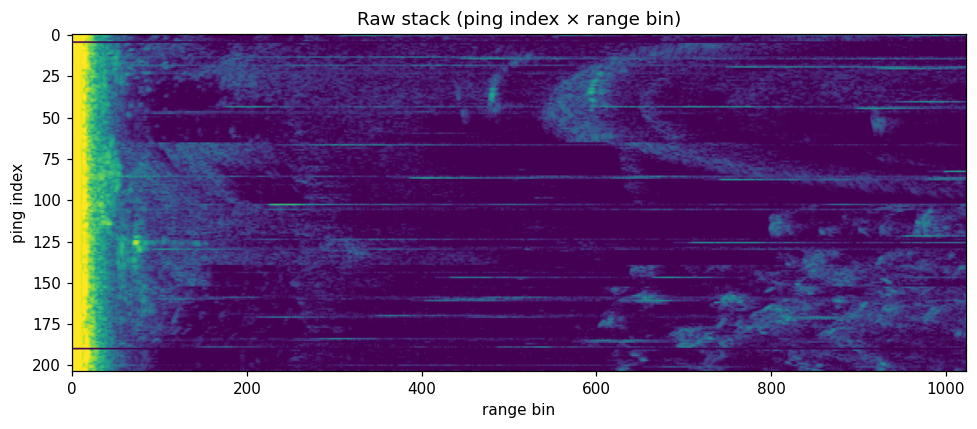

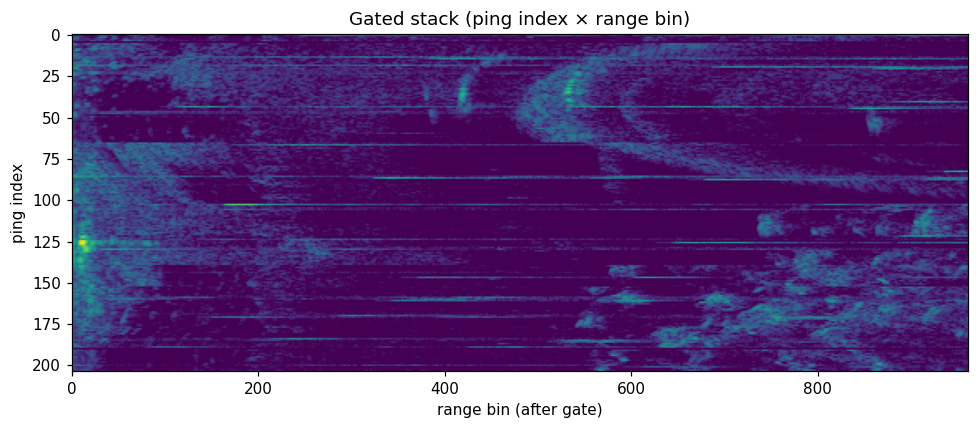

In [5]:
# %% 7) Quick raw stack sanity view (ping index × range), before/after gating

plt.figure(figsize=(9, 4))
plt.imshow(stack, aspect="auto")
plt.title("Raw stack (ping index × range bin)")
plt.xlabel("range bin")
plt.ylabel("ping index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.imshow(stack_g, aspect="auto")
plt.title("Gated stack (ping index × range bin)")
plt.xlabel("range bin (after gate)")
plt.ylabel("ping index")
plt.tight_layout()
plt.show()


In [6]:
# %% 8) Optional: verify angle fields consistency (angle_deg vs angle_ping360)

if "angle_ping360" in df.columns:
    err = (df["angle_deg"].astype(float) - df["angle_ping360"].astype(float) * 0.9).abs()
    print("Angle consistency (|angle_deg - 0.9*angle_ping360|) [deg]:")
    print(err.describe())
else:
    print("angle_ping360 not present; skipped consistency check.")


Angle consistency (|angle_deg - 0.9*angle_ping360|) [deg]:
count    204.000000
mean       1.058824
std        0.297726
min        0.400000
25%        0.800000
50%        1.100000
75%        1.300000
max        1.700000
dtype: float64
